In [6]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
iris = datasets.load_iris()
X = iris.data
Y = iris.target 
x, y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
x.shape, y.shape

(torch.Size([150, 4]), torch.Size([150]))

In [8]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=3),
)
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
kl_weight = 0.01
for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

- Accuracy: 98.000000 %
- CE : 0.05, KL : 3.25


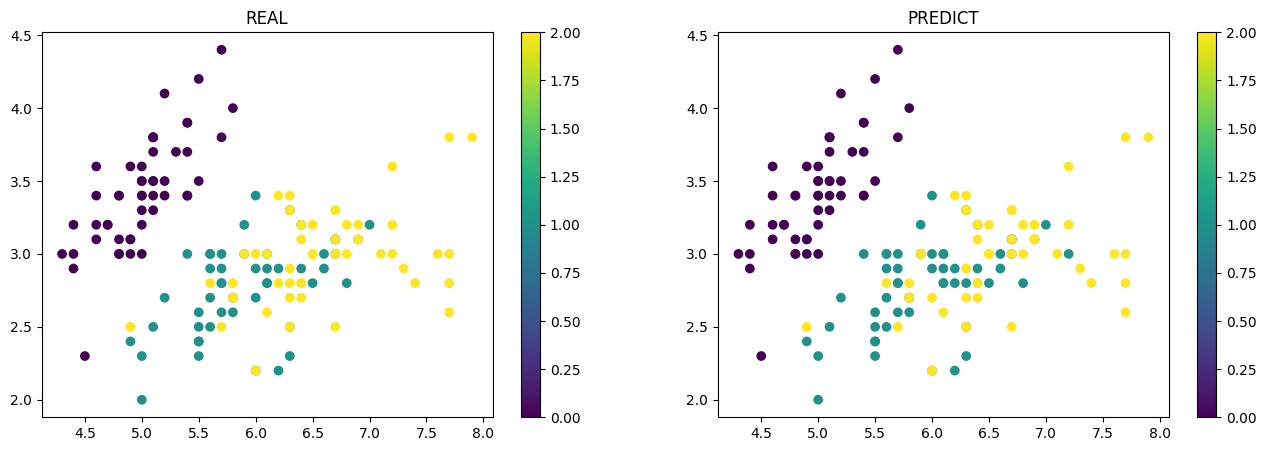

In [10]:
def draw_plot(predicted) :
    fig = plt.figure(figsize = (16, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    z1_plot = ax1.scatter(X[:, 0], X[:, 1], c = Y)
    z2_plot = ax2.scatter(X[:, 0], X[:, 1], c = predicted)

    plt.colorbar(z1_plot,ax=ax1)
    plt.colorbar(z2_plot,ax=ax2)

    ax1.set_title("REAL")
    ax2.set_title("PREDICT")

    plt.show()

pre = model(x)
_, predicted = torch.max(pre.data, 1)
draw_plot(predicted)

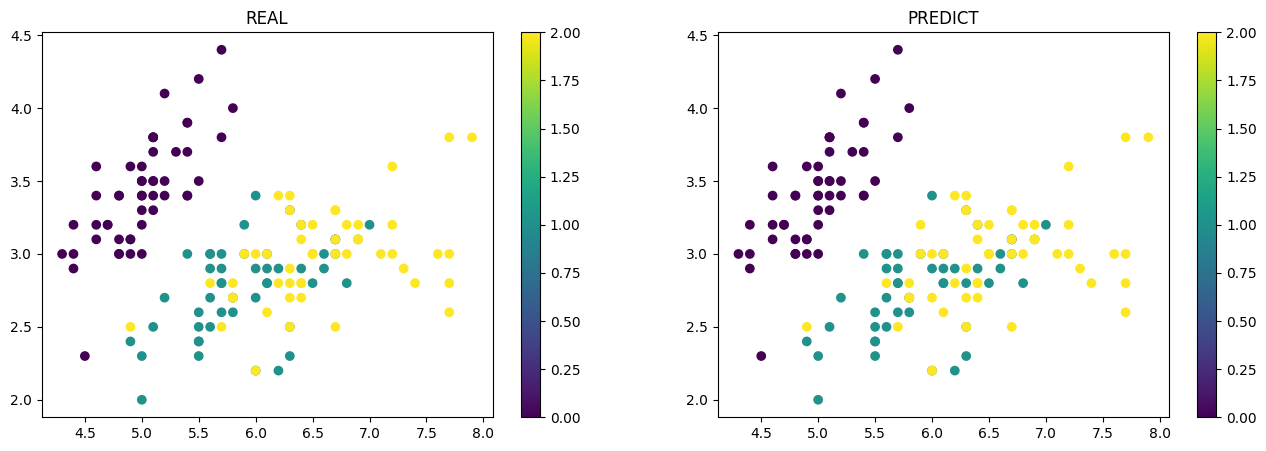

In [11]:
pre = model(x)
_, predicted = torch.max(pre.data, 1)
draw_plot(predicted)

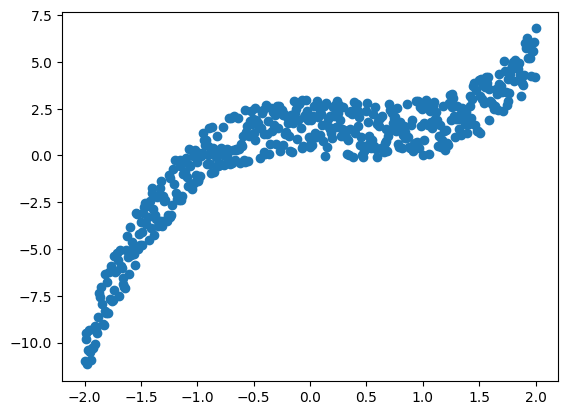

In [12]:
x = torch.linspace(-2, 2, 500)
y = x.pow(3) - x.pow(2) + 3*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [15]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1),
)
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [16]:
kl_weight = 0.1
for step in range(3000):
    pre = model(x)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 0.94, KL : 5.45


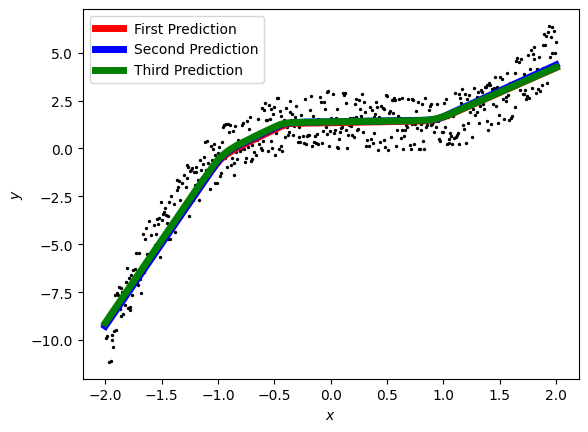

In [17]:
x_test = torch.linspace(-2, 2, 500)
y_test = x_test.pow(3) - x_test.pow(2) + 3*torch.rand(x_test.size())

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.scatter(x_test.data.numpy(), y_test.data.numpy(), color='k', s=2) 

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'r-', linewidth=5, label='First Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'b-', linewidth=5, label='Second Prediction')

y_predict = model(x_test)
plt.plot(x_test.data.numpy(), y_predict.data.numpy(), 'g-', linewidth=5, label='Third Prediction')

plt.legend()

plt.show()

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchbnn as bnn
from torch.utils.data import DataLoader

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='../Data/CIFAR10', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../Data/CIFAR10', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Define the Bayesian CNN model
class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()
        self.conv1 = bnn.BayesConv2d(0, 0.1, 3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = bnn.BayesConv2d(0, 0.1, 32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = bnn.BayesLinear(0, 0.1, 64 * 8 * 8, 256)
        self.fc2 = bnn.BayesLinear(0, 0.1, 256, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BayesianCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
def train_model(model, trainloader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels) + bnn.BKLLoss(reduction='mean', last_layer_only=False)(model)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}")

# Train the model
train_model(model, trainloader, criterion, optimizer, epochs=20)

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Loss: 2.6041
Epoch [2/20], Loss: 2.3333
Epoch [3/20], Loss: 2.3193
Epoch [4/20], Loss: 2.2208
Epoch [5/20], Loss: 2.1098
Epoch [6/20], Loss: 2.0327
Epoch [7/20], Loss: 1.9287
Epoch [8/20], Loss: 1.8290
Epoch [9/20], Loss: 1.7593
Epoch [10/20], Loss: 1.6932
Epoch [11/20], Loss: 1.6356
Epoch [12/20], Loss: 1.5848
Epoch [13/20], Loss: 1.5552
Epoch [14/20], Loss: 1.5184
Epoch [15/20], Loss: 1.4875
Epoch [16/20], Loss: 1.4541
Epoch [17/20], Loss: 1.4235
Epoch [18/20], Loss: 1.3926
Epoch [19/20], Loss: 1.3663
Epoch [20/20], Loss: 1.3335


AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute 'next'

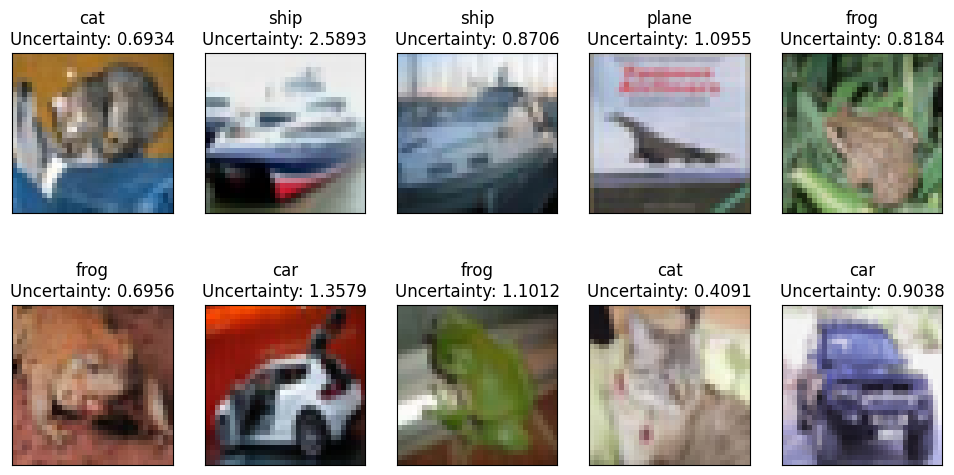

In [24]:
# Evaluate the model and estimate uncertainty
def evaluate_model_with_uncertainty(model, testloader, num_samples=10):
    model.eval()
    all_preds = []
    all_uncertainties = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_preds = []
            
            for _ in range(num_samples):
                outputs = model(inputs)
                batch_preds.append(outputs)
            
            batch_preds = torch.stack(batch_preds)
            mean_preds = batch_preds.mean(dim=0)
            uncertainty = batch_preds.var(dim=0).mean(dim=1)
            
            all_preds.append(mean_preds)
            all_uncertainties.append(uncertainty)
    
    return torch.cat(all_preds), torch.cat(all_uncertainties)

# Evaluate the model with uncertainty estimation
preds, uncertainties = evaluate_model_with_uncertainty(model, testloader)

# Example of plotting uncertainty
def plot_uncertainty(preds, uncertainties, testloader):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    dataiter = iter(testloader)
    images, labels = next(dataiter)  # Corrected here

    fig = plt.figure(figsize=(12, 6))
    for idx in range(10):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
        img = images[idx] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        title = f"{classes[labels[idx]]}\nUncertainty: {uncertainties[idx]:.4f}"
        ax.set_title(title)
    
    plt.show()

# Plot uncertainty for some test images
plot_uncertainty(preds, uncertainties, testloader)

In [ ]:
def func_non(a):
    a+=1
    return a